In [1]:
import os
import numpy as np
from PIL import Image
from datetime import datetime, timedelta
from dotenv import load_dotenv
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, text
from geo_utils import table_dict, og_table_dict
from rasterio import features
from rasterio.transform import from_bounds
import geopandas as gpd
from copy import deepcopy
from io import BytesIO
from tqdm import tqdm
import imageio.v2 as imageio

In [2]:
load_dotenv('./conf.env')
conn_str = os.getenv('CONN_STR')
engine = create_engine(conn_str)
conn = engine.connect()

In [ ]:
real_query = '''
WITH current_object AS (
    SELECT id, shape
    FROM public.g1
    WHERE id = thisid
),
next_objects AS (
    SELECT 
        id, 
        shape, 
        'g1' AS table_name 
    FROM public.g1
    WHERE date_trunc('second', time) = 'timestamp'
    UNION ALL
    SELECT 
        id, 
        shape, 
        'g2' AS table_name 
    FROM public.g2
    WHERE date_trunc('second', time) = 'timestamp'
    UNION ALL
    SELECT
        id, 
        shape, 
        'g3' AS table_name 
    FROM public.g3
    WHERE date_trunc('second', time) = 'timestamp'
    UNION ALL
    SELECT
        id, 
        shape, 
        'g4' AS table_name 
    FROM public.g4
    WHERE date_trunc('second', time) = 'timestamp'
)
SELECT
    next_objects.id AS next_id,
    ST_Area(ST_Intersection(current_object.shape, next_objects.shape)) /
    ST_Area(ST_Union(current_object.shape, next_objects.shape)) AS iou,
    next_objects.table_name
FROM current_object, next_objects
WHERE ST_Intersects(current_object.shape, next_objects.shape);
'''

In [4]:
start_time = datetime(2022, 5, 26, 17, 46, 29)
interval = timedelta(seconds=6)
width, height = 3454, 3454 

In [5]:
str(start_time)

'2022-05-26 17:46:29'

# Visualize 4 different ones

uniform = 2
dot = 4
lane = 5
complex = 65

In [6]:
probabilities = {
    "uniform_granule": {
        "complex_granule": 1,
        "uniform_granule": 3,
        "granule_with_dot": 1,
        "granule_with_lane": 1,
    },
    "complex_granule": {
        "complex_granule": 3,
        "uniform_granule": 1,
        "granule_with_dot": 1,
        "granule_with_lane": 1,
    },
    "granule_with_dot": {
        "complex_granule": 1,
        "uniform_granule": 1,
        "granule_with_dot": 3,
        "granule_with_lane": 1,
    },
    "granule_with_lane": {
        "complex_granule": 1,
        "uniform_granule": 1,
        "granule_with_dot": 1,
        "granule_with_lane": 3,
    },
}

In [7]:
frames = []

# Uniform

In [8]:
id, table = 2, 'uniform_granule'
tables = list(probabilities.keys())
raster_width = raster_height = 3454

id: 2


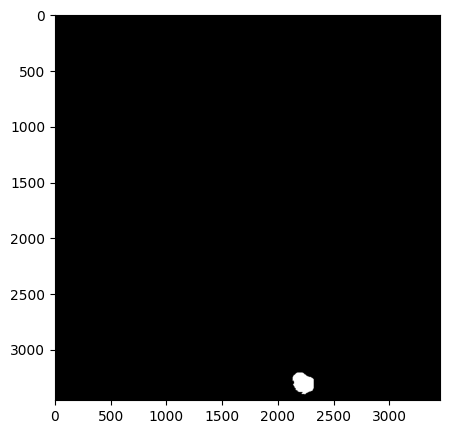

In [9]:
query = f"SELECT id, shape FROM {table} WHERE id={id}"
gdf = gpd.read_postgis(query, engine, geom_col="shape")
print('id:', gdf.iloc[0].id)
gdf = gdf.to_crs("EPSG:4326")
minx, miny, maxx, maxy = gdf.geometry.total_bounds
polygon = gdf.geometry.iloc[0]
transform = from_bounds(0, 0, raster_width, raster_height, raster_width, raster_height)
raster = features.rasterize(
    [(polygon, 1)],
    out_shape=(raster_height, raster_width),
    transform=transform,
    fill=0,
    dtype='uint8'
)
plt.figure(figsize=(5, 5))
plt.imshow(raster, cmap="gray")
plt.show()
frames.append(raster)

In [10]:
for i in range(199):
    time = start_time + interval * (i + 1)
    query = (
        real_query.replace("thisid", str(id))
        .replace("timestamp", str(time))
        .replace("g1", table)
    )
    new_tables = deepcopy(tables)
    new_tables.remove(table)
    for j in range(2, 5):
        query = query.replace(f"g{j}", new_tables[j - 2])
    results = conn.execute(text(query))
    rows = results.fetchall()
    if len(rows) == 0:
        frames.append(np.zeros((3454, 3454), dtype=np.uint8))
        continue
    scores = np.array([r[1] * probabilities[table][r[2]] for r in rows])
    id, _, table = rows[np.argmax(scores)]
    query = f"SELECT id, shape FROM {table} WHERE id={id}"
    print(query)
    gdf = gpd.read_postgis(query, engine, geom_col="shape")
    gdf = gdf.to_crs("EPSG:4326")
    minx, miny, maxx, maxy = gdf.geometry.total_bounds
    polygon = gdf.geometry.iloc[0]
    transform = from_bounds(
        0, 0, raster_width, raster_height, raster_width, raster_height
    )
    raster = features.rasterize(
        [(polygon, 1)],  # Polygon with a value of 1
        out_shape=(raster_height, raster_width),
        transform=transform,
        fill=0,  # Background value
        dtype="uint8",
    )
    frames.append(raster)
    # plt.figure(figsize=(5, 5))
    # plt.imshow(raster, cmap="gray")
    # plt.show()

SELECT id, shape FROM uniform_granule WHERE id=5434
SELECT id, shape FROM complex_granule WHERE id=23193
SELECT id, shape FROM complex_granule WHERE id=34068
SELECT id, shape FROM complex_granule WHERE id=29109
SELECT id, shape FROM complex_granule WHERE id=10366
SELECT id, shape FROM complex_granule WHERE id=22279
SELECT id, shape FROM complex_granule WHERE id=26541
SELECT id, shape FROM granule_with_lane WHERE id=3433
SELECT id, shape FROM uniform_granule WHERE id=3628
SELECT id, shape FROM uniform_granule WHERE id=2022
SELECT id, shape FROM uniform_granule WHERE id=4678
SELECT id, shape FROM uniform_granule WHERE id=2862
SELECT id, shape FROM uniform_granule WHERE id=3163
SELECT id, shape FROM uniform_granule WHERE id=405
SELECT id, shape FROM uniform_granule WHERE id=1593
SELECT id, shape FROM uniform_granule WHERE id=6032
SELECT id, shape FROM uniform_granule WHERE id=3565
SELECT id, shape FROM uniform_granule WHERE id=5156
SELECT id, shape FROM granule_with_dot WHERE id=4325
SELE

# Granule with dot

In [11]:
id, table = 4, 'granule_with_dot'
tables = list(probabilities.keys())
raster_width = raster_height = 3454

id: 4


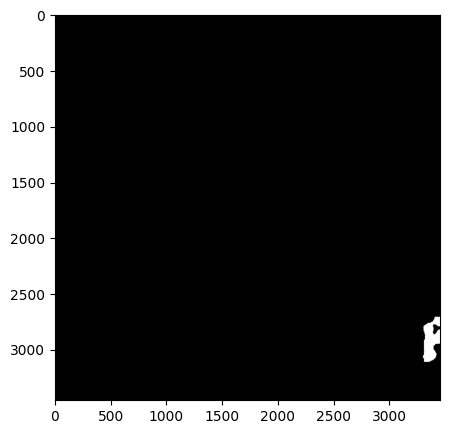

In [12]:
query = f"SELECT id, shape FROM {table} WHERE id={id}"
gdf = gpd.read_postgis(query, engine, geom_col="shape")
print('id:', gdf.iloc[0].id)
gdf = gdf.to_crs("EPSG:4326")
minx, miny, maxx, maxy = gdf.geometry.total_bounds
polygon = gdf.geometry.iloc[0]
transform = from_bounds(0, 0, raster_width, raster_height, raster_width, raster_height)
raster = features.rasterize(
    [(polygon, 1)],
    out_shape=(raster_height, raster_width),
    transform=transform,
    fill=0,
    dtype='uint8'
)
plt.figure(figsize=(5, 5))
plt.imshow(raster, cmap="gray")
plt.show()
frames[0][raster==1] = 2

In [13]:
for i in range(199):
    time = start_time + interval * (i + 1)
    query = (
        real_query.replace("thisid", str(id))
        .replace("timestamp", str(time))
        .replace("g1", table)
    )
    new_tables = deepcopy(tables)
    new_tables.remove(table)
    for j in range(2, 5):
        query = query.replace(f"g{j}", new_tables[j - 2])
    results = conn.execute(text(query))
    rows = results.fetchall()
    if len(rows) == 0:
        continue
    scores = np.array([r[1] * probabilities[table][r[2]] for r in rows])
    id, _, table = rows[np.argmax(scores)]
    query = f"SELECT id, shape FROM {table} WHERE id={id}"
    print(query)
    gdf = gpd.read_postgis(query, engine, geom_col="shape")
    gdf = gdf.to_crs("EPSG:4326")
    minx, miny, maxx, maxy = gdf.geometry.total_bounds
    polygon = gdf.geometry.iloc[0]
    transform = from_bounds(
        0, 0, raster_width, raster_height, raster_width, raster_height
    )
    raster = features.rasterize(
        [(polygon, 1)],  # Polygon with a value of 1
        out_shape=(raster_height, raster_width),
        transform=transform,
        fill=0,  # Background value
        dtype="uint8",
    )
    frames[i+1][raster==1] = 2
    # plt.figure(figsize=(5, 5))
    # plt.imshow(raster, cmap="gray")
    # plt.show()

SELECT id, shape FROM granule_with_dot WHERE id=8633
SELECT id, shape FROM granule_with_dot WHERE id=6311
SELECT id, shape FROM granule_with_dot WHERE id=9217
SELECT id, shape FROM granule_with_dot WHERE id=7900
SELECT id, shape FROM granule_with_dot WHERE id=2856
SELECT id, shape FROM granule_with_dot WHERE id=6070
SELECT id, shape FROM granule_with_dot WHERE id=7208
SELECT id, shape FROM granule_with_dot WHERE id=5043
SELECT id, shape FROM granule_with_dot WHERE id=5926
SELECT id, shape FROM granule_with_dot WHERE id=3274
SELECT id, shape FROM granule_with_dot WHERE id=7509
SELECT id, shape FROM granule_with_dot WHERE id=4690
SELECT id, shape FROM granule_with_dot WHERE id=5150
SELECT id, shape FROM granule_with_dot WHERE id=691
SELECT id, shape FROM granule_with_dot WHERE id=2545
SELECT id, shape FROM granule_with_dot WHERE id=9549
SELECT id, shape FROM granule_with_dot WHERE id=5828
SELECT id, shape FROM granule_with_dot WHERE id=8225
SELECT id, shape FROM complex_granule WHERE id=

# Granule with lane

In [14]:
id, table = 5, 'granule_with_lane'
tables = list(probabilities.keys())
raster_width = raster_height = 3454

id: 5


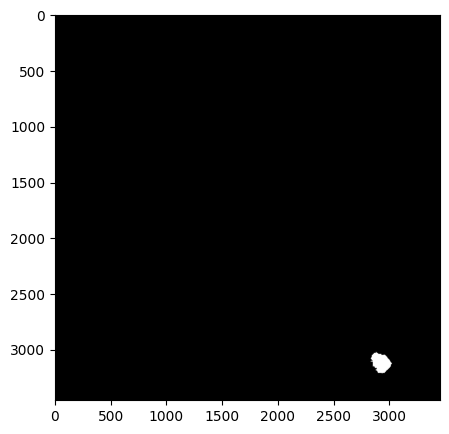

In [15]:
query = f"SELECT id, shape FROM {table} WHERE id={id}"
gdf = gpd.read_postgis(query, engine, geom_col="shape")
print('id:', gdf.iloc[0].id)
gdf = gdf.to_crs("EPSG:4326")
minx, miny, maxx, maxy = gdf.geometry.total_bounds
polygon = gdf.geometry.iloc[0]
transform = from_bounds(0, 0, raster_width, raster_height, raster_width, raster_height)
raster = features.rasterize(
    [(polygon, 1)],
    out_shape=(raster_height, raster_width),
    transform=transform,
    fill=0,
    dtype='uint8'
)
plt.figure(figsize=(5, 5))
plt.imshow(raster, cmap="gray")
plt.show()
frames[0][raster==1] = 3

In [16]:
for i in range(199):
    time = start_time + interval * (i + 1)
    query = (
        real_query.replace("thisid", str(id))
        .replace("timestamp", str(time))
        .replace("g1", table)
    )
    new_tables = deepcopy(tables)
    new_tables.remove(table)
    for j in range(2, 5):
        query = query.replace(f"g{j}", new_tables[j - 2])
    results = conn.execute(text(query))
    rows = results.fetchall()
    if len(rows) == 0:
        continue
    scores = np.array([r[1] * probabilities[table][r[2]] for r in rows])
    id, _, table = rows[np.argmax(scores)]
    query = f"SELECT id, shape FROM {table} WHERE id={id}"
    print(query)
    gdf = gpd.read_postgis(query, engine, geom_col="shape")
    gdf = gdf.to_crs("EPSG:4326")
    minx, miny, maxx, maxy = gdf.geometry.total_bounds
    polygon = gdf.geometry.iloc[0]
    transform = from_bounds(
        0, 0, raster_width, raster_height, raster_width, raster_height
    )
    raster = features.rasterize(
        [(polygon, 1)],  # Polygon with a value of 1
        out_shape=(raster_height, raster_width),
        transform=transform,
        fill=0,  # Background value
        dtype="uint8",
    )
    frames[i+1][raster==1] = 3
    # plt.figure(figsize=(5, 5))
    # plt.imshow(raster, cmap="gray")
    # plt.show()

SELECT id, shape FROM granule_with_lane WHERE id=6043
SELECT id, shape FROM granule_with_lane WHERE id=4327
SELECT id, shape FROM granule_with_lane WHERE id=6443
SELECT id, shape FROM granule_with_lane WHERE id=5513
SELECT id, shape FROM complex_granule WHERE id=10378
SELECT id, shape FROM complex_granule WHERE id=22290
SELECT id, shape FROM complex_granule WHERE id=26555
SELECT id, shape FROM complex_granule WHERE id=18545
SELECT id, shape FROM complex_granule WHERE id=21746
SELECT id, shape FROM complex_granule WHERE id=11887
SELECT id, shape FROM complex_granule WHERE id=27703
SELECT id, shape FROM complex_granule WHERE id=17227
SELECT id, shape FROM complex_granule WHERE id=18890
SELECT id, shape FROM complex_granule WHERE id=2511
SELECT id, shape FROM complex_granule WHERE id=9209
SELECT id, shape FROM complex_granule WHERE id=35360
SELECT id, shape FROM complex_granule WHERE id=21361
SELECT id, shape FROM complex_granule WHERE id=30447
SELECT id, shape FROM complex_granule WHERE 

# Complex

In [17]:
id, table = 65, 'complex_granule'
tables = list(probabilities.keys())
raster_width = raster_height = 3454

id: 65


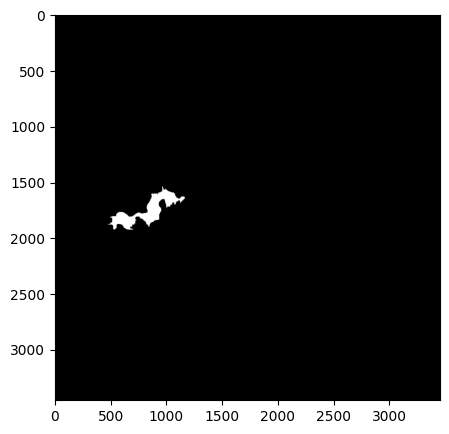

In [18]:
query = f"SELECT id, shape FROM {table} WHERE id={id}"
gdf = gpd.read_postgis(query, engine, geom_col="shape")
print('id:', gdf.iloc[0].id)
gdf = gdf.to_crs("EPSG:4326")
minx, miny, maxx, maxy = gdf.geometry.total_bounds
polygon = gdf.geometry.iloc[0]
transform = from_bounds(0, 0, raster_width, raster_height, raster_width, raster_height)
raster = features.rasterize(
    [(polygon, 1)],
    out_shape=(raster_height, raster_width),
    transform=transform,
    fill=0,
    dtype='uint8'
)
plt.figure(figsize=(5, 5))
plt.imshow(raster, cmap="gray")
plt.show()
frames[0][raster==1] = 4

In [19]:
for i in range(199):
    time = start_time + interval * (i + 1)
    query = (
        real_query.replace("thisid", str(id))
        .replace("timestamp", str(time))
        .replace("g1", table)
    )
    new_tables = deepcopy(tables)
    new_tables.remove(table)
    for j in range(2, 5):
        query = query.replace(f"g{j}", new_tables[j - 2])
    results = conn.execute(text(query))
    rows = results.fetchall()
    if len(rows) == 0:
        continue
    scores = np.array([r[1] * probabilities[table][r[2]] for r in rows])
    id, _, table = rows[np.argmax(scores)]
    query = f"SELECT id, shape FROM {table} WHERE id={id}"
    print(query)
    gdf = gpd.read_postgis(query, engine, geom_col="shape")
    gdf = gdf.to_crs("EPSG:4326")
    minx, miny, maxx, maxy = gdf.geometry.total_bounds
    polygon = gdf.geometry.iloc[0]
    transform = from_bounds(
        0, 0, raster_width, raster_height, raster_width, raster_height
    )
    raster = features.rasterize(
        [(polygon, 1)],  # Polygon with a value of 1
        out_shape=(raster_height, raster_width),
        transform=transform,
        fill=0,  # Background value
        dtype="uint8",
    )
    frames[i+1][raster==1] = 4
    # plt.figure(figsize=(5, 5))
    # plt.imshow(raster, cmap="gray")
    # plt.show()

SELECT id, shape FROM complex_granule WHERE id=31921
SELECT id, shape FROM complex_granule WHERE id=23275
SELECT id, shape FROM complex_granule WHERE id=34156
SELECT id, shape FROM complex_granule WHERE id=29212
SELECT id, shape FROM complex_granule WHERE id=10474
SELECT id, shape FROM complex_granule WHERE id=22370
SELECT id, shape FROM complex_granule WHERE id=26641
SELECT id, shape FROM complex_granule WHERE id=18622
SELECT id, shape FROM complex_granule WHERE id=21846
SELECT id, shape FROM complex_granule WHERE id=11992
SELECT id, shape FROM complex_granule WHERE id=27807
SELECT id, shape FROM complex_granule WHERE id=17331
SELECT id, shape FROM complex_granule WHERE id=18997
SELECT id, shape FROM complex_granule WHERE id=2607
SELECT id, shape FROM complex_granule WHERE id=9311
SELECT id, shape FROM complex_granule WHERE id=35457
SELECT id, shape FROM complex_granule WHERE id=21456
SELECT id, shape FROM complex_granule WHERE id=30545
SELECT id, shape FROM granule_with_dot WHERE id=

# Uniform

id: 3


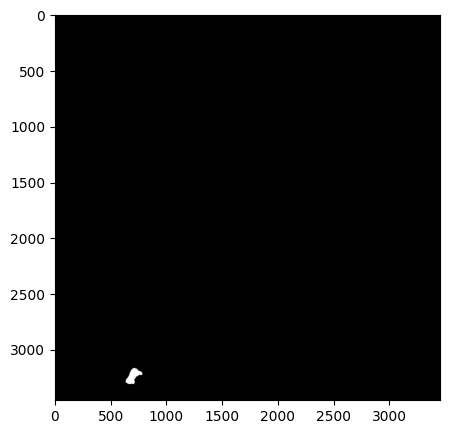

In [20]:
id, table = 3, 'uniform_granule'
tables = list(probabilities.keys())
raster_width = raster_height = 3454

query = f"SELECT id, shape FROM {table} WHERE id={id}"
gdf = gpd.read_postgis(query, engine, geom_col="shape")
print('id:', gdf.iloc[0].id)
gdf = gdf.to_crs("EPSG:4326")
minx, miny, maxx, maxy = gdf.geometry.total_bounds
polygon = gdf.geometry.iloc[0]
transform = from_bounds(0, 0, raster_width, raster_height, raster_width, raster_height)
raster = features.rasterize(
    [(polygon, 1)],
    out_shape=(raster_height, raster_width),
    transform=transform,
    fill=0,
    dtype='uint8'
)
plt.figure(figsize=(5, 5))
plt.imshow(raster, cmap="gray")
plt.show()
frames[0][raster==1] = 5

In [21]:
for i in range(199):
    time = start_time + interval * (i + 1)
    query = (
        real_query.replace("thisid", str(id))
        .replace("timestamp", str(time))
        .replace("g1", table)
    )
    new_tables = deepcopy(tables)
    new_tables.remove(table)
    for j in range(2, 5):
        query = query.replace(f"g{j}", new_tables[j - 2])
    results = conn.execute(text(query))
    rows = results.fetchall()
    if len(rows) == 0:
        continue
    scores = np.array([r[1] * probabilities[table][r[2]] for r in rows])
    id, _, table = rows[np.argmax(scores)]
    query = f"SELECT id, shape FROM {table} WHERE id={id}"
    print(query)
    gdf = gpd.read_postgis(query, engine, geom_col="shape")
    gdf = gdf.to_crs("EPSG:4326")
    minx, miny, maxx, maxy = gdf.geometry.total_bounds
    polygon = gdf.geometry.iloc[0]
    transform = from_bounds(
        0, 0, raster_width, raster_height, raster_width, raster_height
    )
    raster = features.rasterize(
        [(polygon, 1)],  # Polygon with a value of 1
        out_shape=(raster_height, raster_width),
        transform=transform,
        fill=0,  # Background value
        dtype="uint8",
    )
    frames[i+1][raster==1] = 5

SELECT id, shape FROM complex_granule WHERE id=31886
SELECT id, shape FROM complex_granule WHERE id=23230
SELECT id, shape FROM complex_granule WHERE id=34114
SELECT id, shape FROM complex_granule WHERE id=29141
SELECT id, shape FROM complex_granule WHERE id=10400
SELECT id, shape FROM complex_granule WHERE id=22310
SELECT id, shape FROM complex_granule WHERE id=26567
SELECT id, shape FROM granule_with_dot WHERE id=5041
SELECT id, shape FROM complex_granule WHERE id=21753
SELECT id, shape FROM complex_granule WHERE id=11899
SELECT id, shape FROM complex_granule WHERE id=27717
SELECT id, shape FROM complex_granule WHERE id=17240
SELECT id, shape FROM complex_granule WHERE id=18892
SELECT id, shape FROM complex_granule WHERE id=2513
SELECT id, shape FROM complex_granule WHERE id=9213
SELECT id, shape FROM complex_granule WHERE id=35364
SELECT id, shape FROM complex_granule WHERE id=21370
SELECT id, shape FROM complex_granule WHERE id=30461
SELECT id, shape FROM complex_granule WHERE id=1

# Granule with dot

id: 5


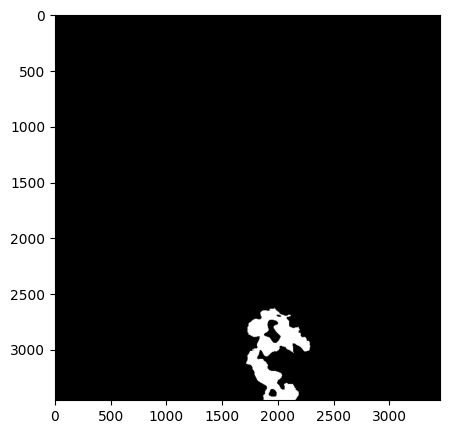

In [22]:
id, table = 5, 'granule_with_dot'
tables = list(probabilities.keys())
raster_width = raster_height = 3454

query = f"SELECT id, shape FROM {table} WHERE id={id}"
gdf = gpd.read_postgis(query, engine, geom_col="shape")
print('id:', gdf.iloc[0].id)
gdf = gdf.to_crs("EPSG:4326")
minx, miny, maxx, maxy = gdf.geometry.total_bounds
polygon = gdf.geometry.iloc[0]
transform = from_bounds(0, 0, raster_width, raster_height, raster_width, raster_height)
raster = features.rasterize(
    [(polygon, 1)],
    out_shape=(raster_height, raster_width),
    transform=transform,
    fill=0,
    dtype='uint8'
)
plt.figure(figsize=(5, 5))
plt.imshow(raster, cmap="gray")
plt.show()
frames[0][raster==1] = 6

In [23]:
for i in range(199):
    time = start_time + interval * (i + 1)
    query = (
        real_query.replace("thisid", str(id))
        .replace("timestamp", str(time))
        .replace("g1", table)
    )
    new_tables = deepcopy(tables)
    new_tables.remove(table)
    for j in range(2, 5):
        query = query.replace(f"g{j}", new_tables[j - 2])
    results = conn.execute(text(query))
    rows = results.fetchall()
    if len(rows) == 0:
        continue
    scores = np.array([r[1] * probabilities[table][r[2]] for r in rows])
    id, _, table = rows[np.argmax(scores)]
    query = f"SELECT id, shape FROM {table} WHERE id={id}"
    print(query)
    gdf = gpd.read_postgis(query, engine, geom_col="shape")
    gdf = gdf.to_crs("EPSG:4326")
    minx, miny, maxx, maxy = gdf.geometry.total_bounds
    polygon = gdf.geometry.iloc[0]
    transform = from_bounds(
        0, 0, raster_width, raster_height, raster_width, raster_height
    )
    raster = features.rasterize(
        [(polygon, 1)],  # Polygon with a value of 1
        out_shape=(raster_height, raster_width),
        transform=transform,
        fill=0,  # Background value
        dtype="uint8",
    )
    frames[i+1][raster==1] = 6

SELECT id, shape FROM granule_with_dot WHERE id=8638
SELECT id, shape FROM granule_with_dot WHERE id=6314
SELECT id, shape FROM granule_with_dot WHERE id=9220
SELECT id, shape FROM granule_with_dot WHERE id=7903
SELECT id, shape FROM granule_with_dot WHERE id=2859
SELECT id, shape FROM granule_with_dot WHERE id=6073
SELECT id, shape FROM granule_with_dot WHERE id=7211
SELECT id, shape FROM complex_granule WHERE id=18569
SELECT id, shape FROM complex_granule WHERE id=21767
SELECT id, shape FROM complex_granule WHERE id=11906
SELECT id, shape FROM complex_granule WHERE id=27723
SELECT id, shape FROM complex_granule WHERE id=17248
SELECT id, shape FROM complex_granule WHERE id=18907
SELECT id, shape FROM complex_granule WHERE id=2529
SELECT id, shape FROM complex_granule WHERE id=9227
SELECT id, shape FROM complex_granule WHERE id=35379
SELECT id, shape FROM complex_granule WHERE id=21382
SELECT id, shape FROM complex_granule WHERE id=30467
SELECT id, shape FROM complex_granule WHERE id=1

# Granule with lane

id: 7


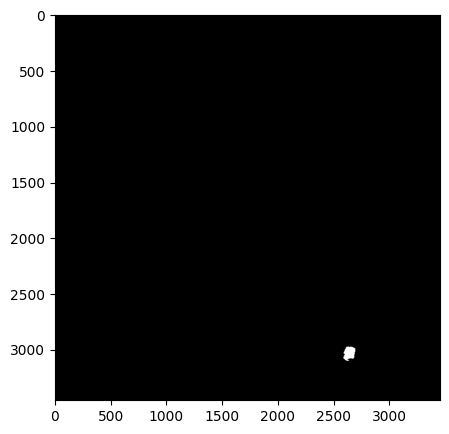

In [24]:
id, table = 7, 'granule_with_lane'
tables = list(probabilities.keys())
raster_width = raster_height = 3454

query = f"SELECT id, shape FROM {table} WHERE id={id}"
gdf = gpd.read_postgis(query, engine, geom_col="shape")
print('id:', gdf.iloc[0].id)
gdf = gdf.to_crs("EPSG:4326")
minx, miny, maxx, maxy = gdf.geometry.total_bounds
polygon = gdf.geometry.iloc[0]
transform = from_bounds(0, 0, raster_width, raster_height, raster_width, raster_height)
raster = features.rasterize(
    [(polygon, 1)],
    out_shape=(raster_height, raster_width),
    transform=transform,
    fill=0,
    dtype='uint8'
)
plt.figure(figsize=(5, 5))
plt.imshow(raster, cmap="gray")
plt.show()
frames[0][raster==1] = 7

In [25]:
for i in range(199):
    time = start_time + interval * (i + 1)
    query = (
        real_query.replace("thisid", str(id))
        .replace("timestamp", str(time))
        .replace("g1", table)
    )
    new_tables = deepcopy(tables)
    new_tables.remove(table)
    for j in range(2, 5):
        query = query.replace(f"g{j}", new_tables[j - 2])
    results = conn.execute(text(query))
    rows = results.fetchall()
    if len(rows) == 0:
        continue
    scores = np.array([r[1] * probabilities[table][r[2]] for r in rows])
    id, _, table = rows[np.argmax(scores)]
    query = f"SELECT id, shape FROM {table} WHERE id={id}"
    print(query)
    gdf = gpd.read_postgis(query, engine, geom_col="shape")
    gdf = gdf.to_crs("EPSG:4326")
    minx, miny, maxx, maxy = gdf.geometry.total_bounds
    polygon = gdf.geometry.iloc[0]
    transform = from_bounds(
        0, 0, raster_width, raster_height, raster_width, raster_height
    )
    raster = features.rasterize(
        [(polygon, 1)],  # Polygon with a value of 1
        out_shape=(raster_height, raster_width),
        transform=transform,
        fill=0,  # Background value
        dtype="uint8",
    )
    frames[i+1][raster==1] = 7

SELECT id, shape FROM granule_with_lane WHERE id=6044
SELECT id, shape FROM granule_with_lane WHERE id=4326
SELECT id, shape FROM granule_with_lane WHERE id=6442
SELECT id, shape FROM complex_granule WHERE id=29123
SELECT id, shape FROM complex_granule WHERE id=10381
SELECT id, shape FROM complex_granule WHERE id=22294
SELECT id, shape FROM complex_granule WHERE id=26569
SELECT id, shape FROM granule_with_lane WHERE id=3436
SELECT id, shape FROM granule_with_lane WHERE id=4058
SELECT id, shape FROM granule_with_lane WHERE id=2200
SELECT id, shape FROM granule_with_lane WHERE id=5195
SELECT id, shape FROM granule_with_lane WHERE id=3186
SELECT id, shape FROM granule_with_lane WHERE id=3498
SELECT id, shape FROM granule_with_lane WHERE id=497
SELECT id, shape FROM granule_with_lane WHERE id=1753
SELECT id, shape FROM granule_with_lane WHERE id=6717
SELECT id, shape FROM granule_with_lane WHERE id=3991
SELECT id, shape FROM granule_with_lane WHERE id=5752
SELECT id, shape FROM uniform_gra

# Complex

id: 66


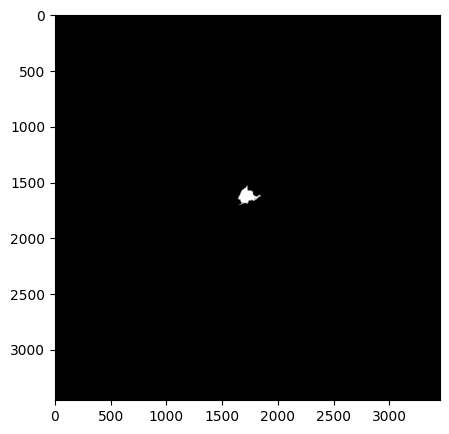

In [26]:
id, table = 66, 'complex_granule'
tables = list(probabilities.keys())
raster_width = raster_height = 3454

query = f"SELECT id, shape FROM {table} WHERE id={id}"
gdf = gpd.read_postgis(query, engine, geom_col="shape")
print('id:', gdf.iloc[0].id)
gdf = gdf.to_crs("EPSG:4326")
minx, miny, maxx, maxy = gdf.geometry.total_bounds
polygon = gdf.geometry.iloc[0]
transform = from_bounds(0, 0, raster_width, raster_height, raster_width, raster_height)
raster = features.rasterize(
    [(polygon, 1)],
    out_shape=(raster_height, raster_width),
    transform=transform,
    fill=0,
    dtype='uint8'
)
plt.figure(figsize=(5, 5))
plt.imshow(raster, cmap="gray")
plt.show()
frames[0][raster==1] = 8

In [27]:
for i in range(199):
    time = start_time + interval * (i + 1)
    query = (
        real_query.replace("thisid", str(id))
        .replace("timestamp", str(time))
        .replace("g1", table)
    )
    new_tables = deepcopy(tables)
    new_tables.remove(table)
    for j in range(2, 5):
        query = query.replace(f"g{j}", new_tables[j - 2])
    results = conn.execute(text(query))
    rows = results.fetchall()
    if len(rows) == 0:
        continue
    scores = np.array([r[1] * probabilities[table][r[2]] for r in rows])
    id, _, table = rows[np.argmax(scores)]
    query = f"SELECT id, shape FROM {table} WHERE id={id}"
    print(query)
    gdf = gpd.read_postgis(query, engine, geom_col="shape")
    gdf = gdf.to_crs("EPSG:4326")
    minx, miny, maxx, maxy = gdf.geometry.total_bounds
    polygon = gdf.geometry.iloc[0]
    transform = from_bounds(
        0, 0, raster_width, raster_height, raster_width, raster_height
    )
    raster = features.rasterize(
        [(polygon, 1)],  # Polygon with a value of 1
        out_shape=(raster_height, raster_width),
        transform=transform,
        fill=0,  # Background value
        dtype="uint8",
    )
    frames[i+1][raster==1] = 8

SELECT id, shape FROM complex_granule WHERE id=31952
SELECT id, shape FROM complex_granule WHERE id=23305
SELECT id, shape FROM complex_granule WHERE id=34191
SELECT id, shape FROM complex_granule WHERE id=29248
SELECT id, shape FROM complex_granule WHERE id=10516
SELECT id, shape FROM complex_granule WHERE id=22424
SELECT id, shape FROM complex_granule WHERE id=26700
SELECT id, shape FROM complex_granule WHERE id=18633
SELECT id, shape FROM complex_granule WHERE id=21841
SELECT id, shape FROM complex_granule WHERE id=11987
SELECT id, shape FROM complex_granule WHERE id=27803
SELECT id, shape FROM complex_granule WHERE id=17328
SELECT id, shape FROM complex_granule WHERE id=18987
SELECT id, shape FROM complex_granule WHERE id=2608
SELECT id, shape FROM complex_granule WHERE id=9308
SELECT id, shape FROM complex_granule WHERE id=35449
SELECT id, shape FROM complex_granule WHERE id=21448
SELECT id, shape FROM complex_granule WHERE id=30518
SELECT id, shape FROM complex_granule WHERE id=1

In [30]:
video_frames = []
for frame in tqdm(frames):
    if np.all(frame==0):
        continue
    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.axis("off")
    fig.patch.set_visible(False)
    ax.imshow(frame, cmap="jet_r")
    buffer = BytesIO()
    plt.savefig(buffer, format="png", bbox_inches="tight", pad_inches=0)
    plt.close(fig)
    video_frames.append(imageio.imread(buffer))

100%|██████████| 200/200 [00:15<00:00, 13.01it/s]


In [31]:
output_filename = f"out.mp4"
fps = 5  # Adjust frames per second as needed

# Create video directly from frames in memory
with imageio.get_writer(output_filename, fps=fps) as writer:
    for frame in video_frames:
        writer.append_data(frame)

print(f"Video saved as {output_filename}")

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (769, 770) to (784, 784) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Video saved as out.mp4
